
# Árbol de decisión para clasificación — Diagnóstico de cáncer de mama (benigno vs maligno)

Objetivo: construir, evaluar e interpretar un **árbol de decisión** que predice **benigno (1)** vs **maligno (0)** a partir de medidas morfológicas de células tumorales.



## ¿Qué vamos a hacer y por qué?

Construiremos un **clasificador binario** que, a partir de medidas morfológicas extraídas de imágenes, prediga si un caso es **benigno (1)** o **maligno (0)**.

¿Por qué un árbol de decisión para este caso?
- Todas las *features* son **numéricas** → no necesitamos *encoding*.
- El problema es **binario y realista** → las métricas se interpretan fácil.
- El árbol se puede **visualizar e interpretar** con reglas claras (si… entonces…).

> Intuición clínica (reglas que esperamos ver): tumores malignos tienden a ser **más grandes**, **menos suaves** y con **bordes más irregulares** (más concavidad).



El dataset: *Breast Cancer Wisconsin*

Cargaremos el dataset desde `sklearn`:
- **569** muestras.
- **30** variables numéricas (promedios, desvíos y peores valores: radio, textura, perímetro, área, concavidad, etc.).
- **target**: `0 = malignant (maligno)`, `1 = benign (benigno)`.

Algunas variables principales:
- `mean radius`: radio medio de núcleos.
- `mean texture`: variación de grises.
- `mean perimeter` / `mean area`: perímetro/área promedio.
- `mean smoothness`: suavidad de contornos.
- `mean compactness`: compacidad (perímetro²/área − 1.0).
- `mean concavity` / `mean concave points`: concavidad media y número de puntos cóncavos.
- Versiones con sufijos `se` (error estándar) y `worst` (peor valor).


In [2]:

from sklearn.datasets import load_breast_cancer
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt

sns.set()

data = load_breast_cancer(as_frame = True)
df = data.frame.copy()
X= df.drop(columns="target")
y=df["target"]

In [6]:
y.value_counts()

,count
target,
1,357
0,212



## ¿Cómo “piensa” un árbol de decisión en clasificación? (sin fórmulas)

1. **Objetivo**: separar clases creando reglas **si… entonces…**.
2. En cada nodo prueba variables y **umbrales** (p. ej. `mean concavity ≤ 0.05`) y elige la división que deja grupos más **puros**.
3. **Pureza** (por defecto): **Gini**.
4. Repite en cada rama hasta no mejorar o alcanzar límites (profundidad, tamaño mínimo, etc.).
5. En hojas, asigna la **clase mayoritaria** (y da probabilidad de clase).



## EDA con propósito: ¿qué separa benignos de malignos?
### 4.1. Variable de tamaño: `mean radius`


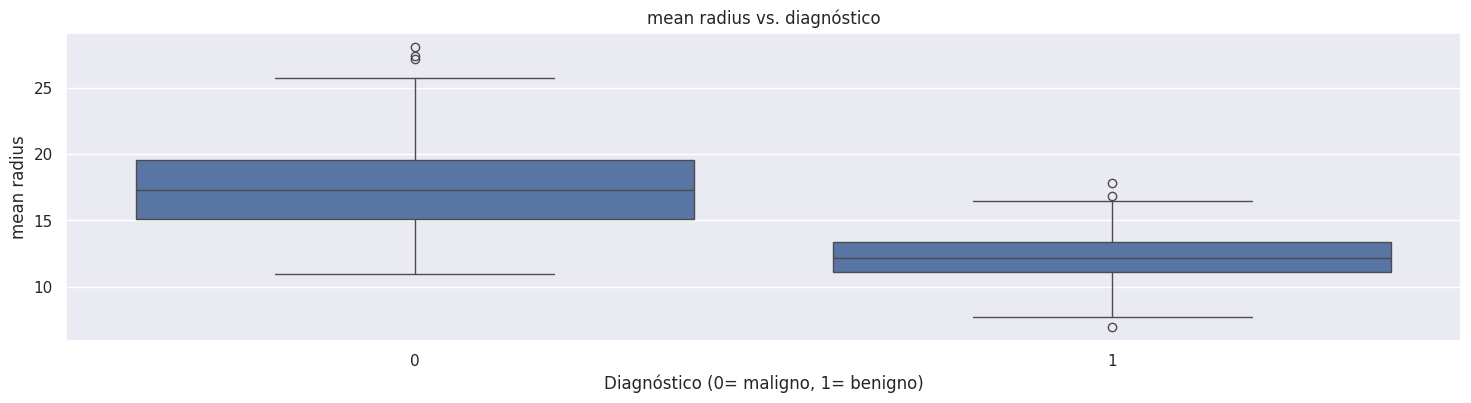

In [9]:
plt.figure(figsize=(18,4))
sns.boxplot(data=df, x="target", y="mean radius")
plt.xlabel("Diagnóstico (0= maligno, 1= benigno)")
plt.title ("mean radius vs. diagnóstico")
plt.show()



Interpretación:



### 4.2. Variable de forma: `mean concavity`


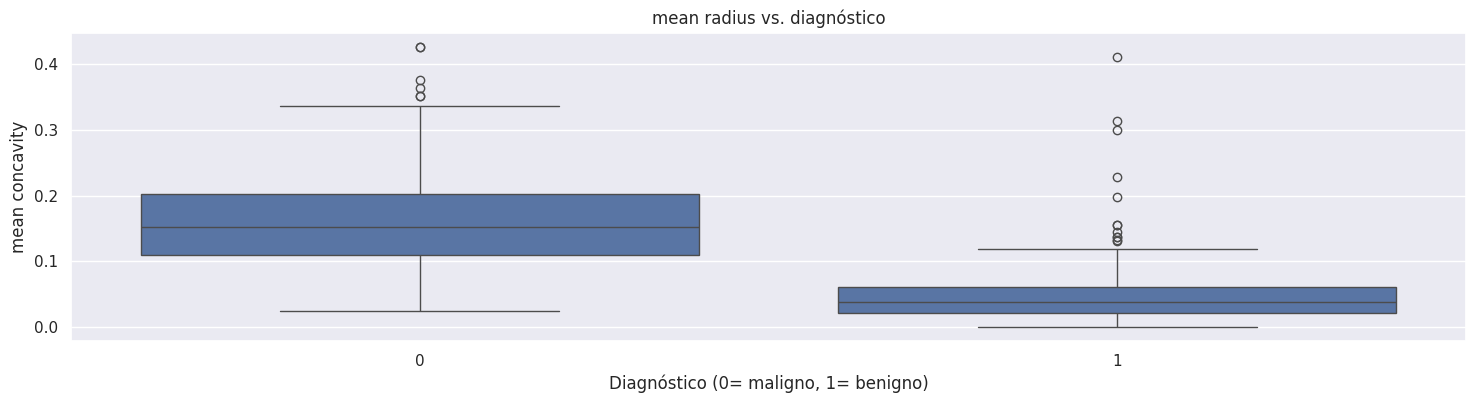

In [10]:
plt.figure(figsize=(18,4))
sns.boxplot(data=df, x="target", y="mean concavity")
plt.xlabel("Diagnóstico (0= maligno, 1= benigno)")
plt.title ("mean radius vs. diagnóstico")
plt.show()



Interpretación: los **malignos** presentan **concavidades mayores** (bordes más irregulares).  
> Nota: podríamos mirar correlaciones, pero en árboles no es imprescindible; el modelo elige lo que más reduce impureza, incluso con multicolinealidad.



## Partición entrenamiento/prueba

Dividimos estratificando para mantener proporción de clases: **80% train / 20% test**.


In [11]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.2, random_state=42, stratify=y)


In [15]:
X_test.shape

(114, 30)


## Entrenamos el árbol (parámetros clave)

Usaremos `DecisionTreeClassifier` controlando **complejidad** con `max_depth` (y opcionalmente `min_samples_leaf`).  
Resumen de hiperparámetros útiles:
- `max_depth`: cuántos “si…” encadenamos.
- `min_samples_split` / `min_samples_leaf`: tamaños mínimos para dividir/terminar (suavizan, reducen varianza).
- `criterion`: Gini (por defecto) o Entropía.
- `random_state`: reproducibilidad.


In [16]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(criterion="gini", max_depth=5, random_state=42)

clf.fit(X_train, y_train)

clf



DecisionTreeClassifier(max_depth=5, random_state=42)


## Evaluación: exactitud, matriz de confusión y reporte

Medimos desempeño en **test**.


In [18]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.3f}")

cm = confusion_matrix(y_test, y_pred)


Accuracy: 0.921


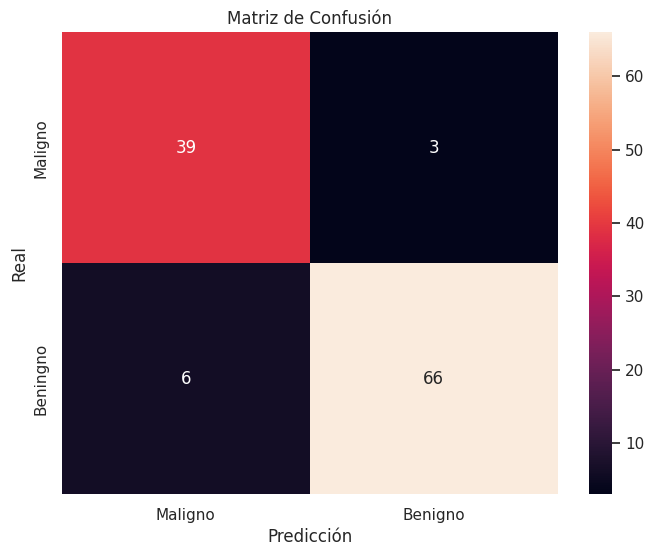

In [21]:
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["Maligno", "Benigno"], yticklabels=["Maligno", "Beningno"])
plt.xlabel("Predicción");
plt.ylabel("Real");
plt.title("Matriz de Confusión")
plt.show()

In [23]:
print(classification_report(y_test, y_pred, target_names=["Maligno", "Benigno"]))

              precision    recall  f1-score   support

     Maligno       0.87      0.93      0.90        42
     Benigno       0.96      0.92      0.94        72

    accuracy                           0.92       114
   macro avg       0.91      0.92      0.92       114
weighted avg       0.92      0.92      0.92       114




**Lectura didáctica**:
- `accuracy` alto (suele ~0.90–0.97) → buen desempeño global.
- **`recall` de “Maligno”** es crítico (minimiza **falsos negativos**).
- Si queremos priorizar *recall* de “Maligno”, podemos luego **ajustar umbral** con `predict_proba` o **ponderar costos** (tema para otra clase).



## Probabilidades y umbrales
Distribución de la probabilidad predicha de **Benigno (1)** en el *set* de test.


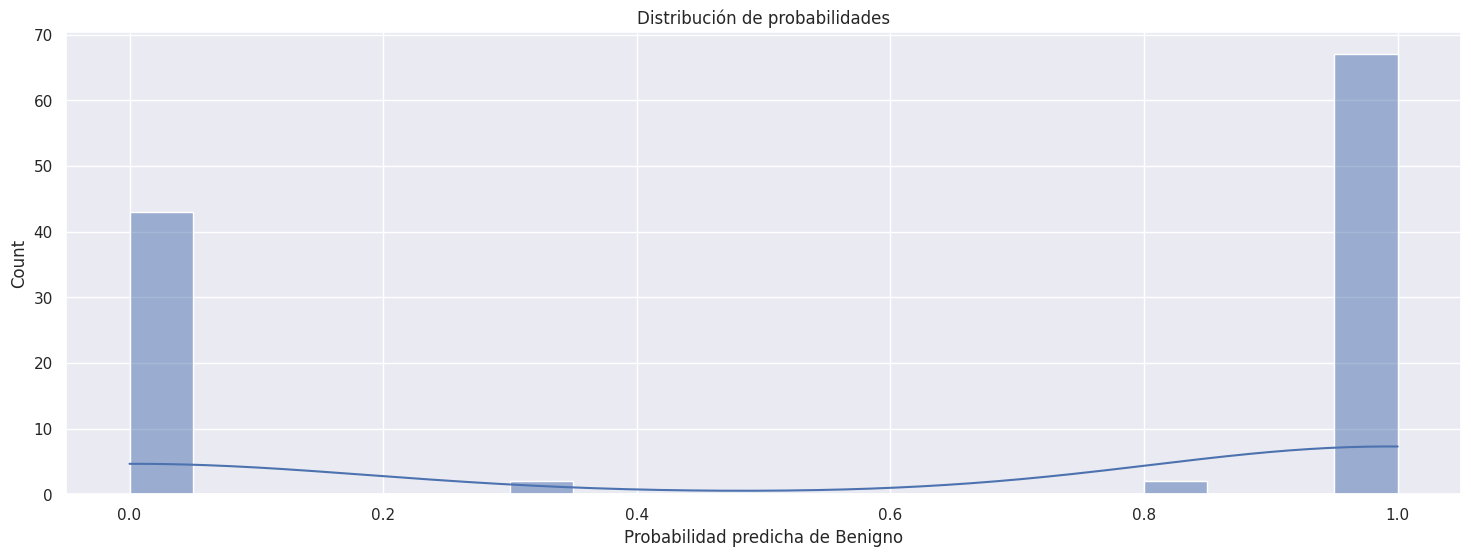

In [24]:

probs = clf.predict_proba(X_test)[:,1] #probabilidad de Beningo
plt.figure(figsize=(18,6))
sns.histplot(probs, bins=20, kde=True)
plt.xlabel("Probabilidad predicha de Benigno")
plt.title("Distribución de probabilidades")
plt.show()


Si muchas probabilidades están en extremos (≈0 o ≈1), el árbol está **seguro**.  
Si se acumulan cerca de 0.5, hay **casos ambiguos** (regiones limítrofes).



## ¿Qué variables usó el árbol? (*Feature importances*)

Las *importances* miden cuánto contribuye cada variable a **reducir impureza** a lo largo del árbol.


In [27]:
importances =pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
importances

,0
worst radius,0.714332
worst concave points,0.118831
texture error,0.053907
worst texture,0.031473
worst concavity,0.016712
worst smoothness,0.012978
area error,0.012371
mean texture,0.011536
worst symmetry,0.010987
worst area,0.008652


<Axes: xlabel='None', ylabel='None'>

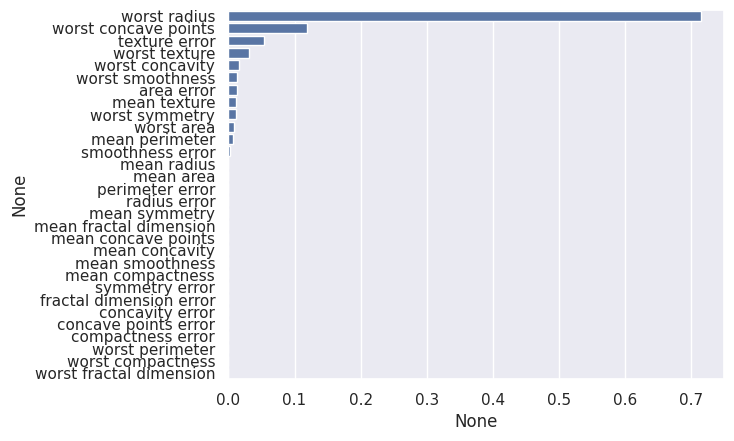

In [28]:
sns.barplot(x=importances, y=importances.index)



Verás arriba variables como **`worst concave points`**, **`worst perimeter`**, **`mean concavity`**, **`worst radius`**, etc.  
Confirma que el modelo se apoya en **tamaño/forma/concavidad** para separar clases (coherente con la literatura).



## Leer el árbol (visualización de reglas)

Mostramos los **primeros niveles** (para legibilidad) y cómo leer un nodo.


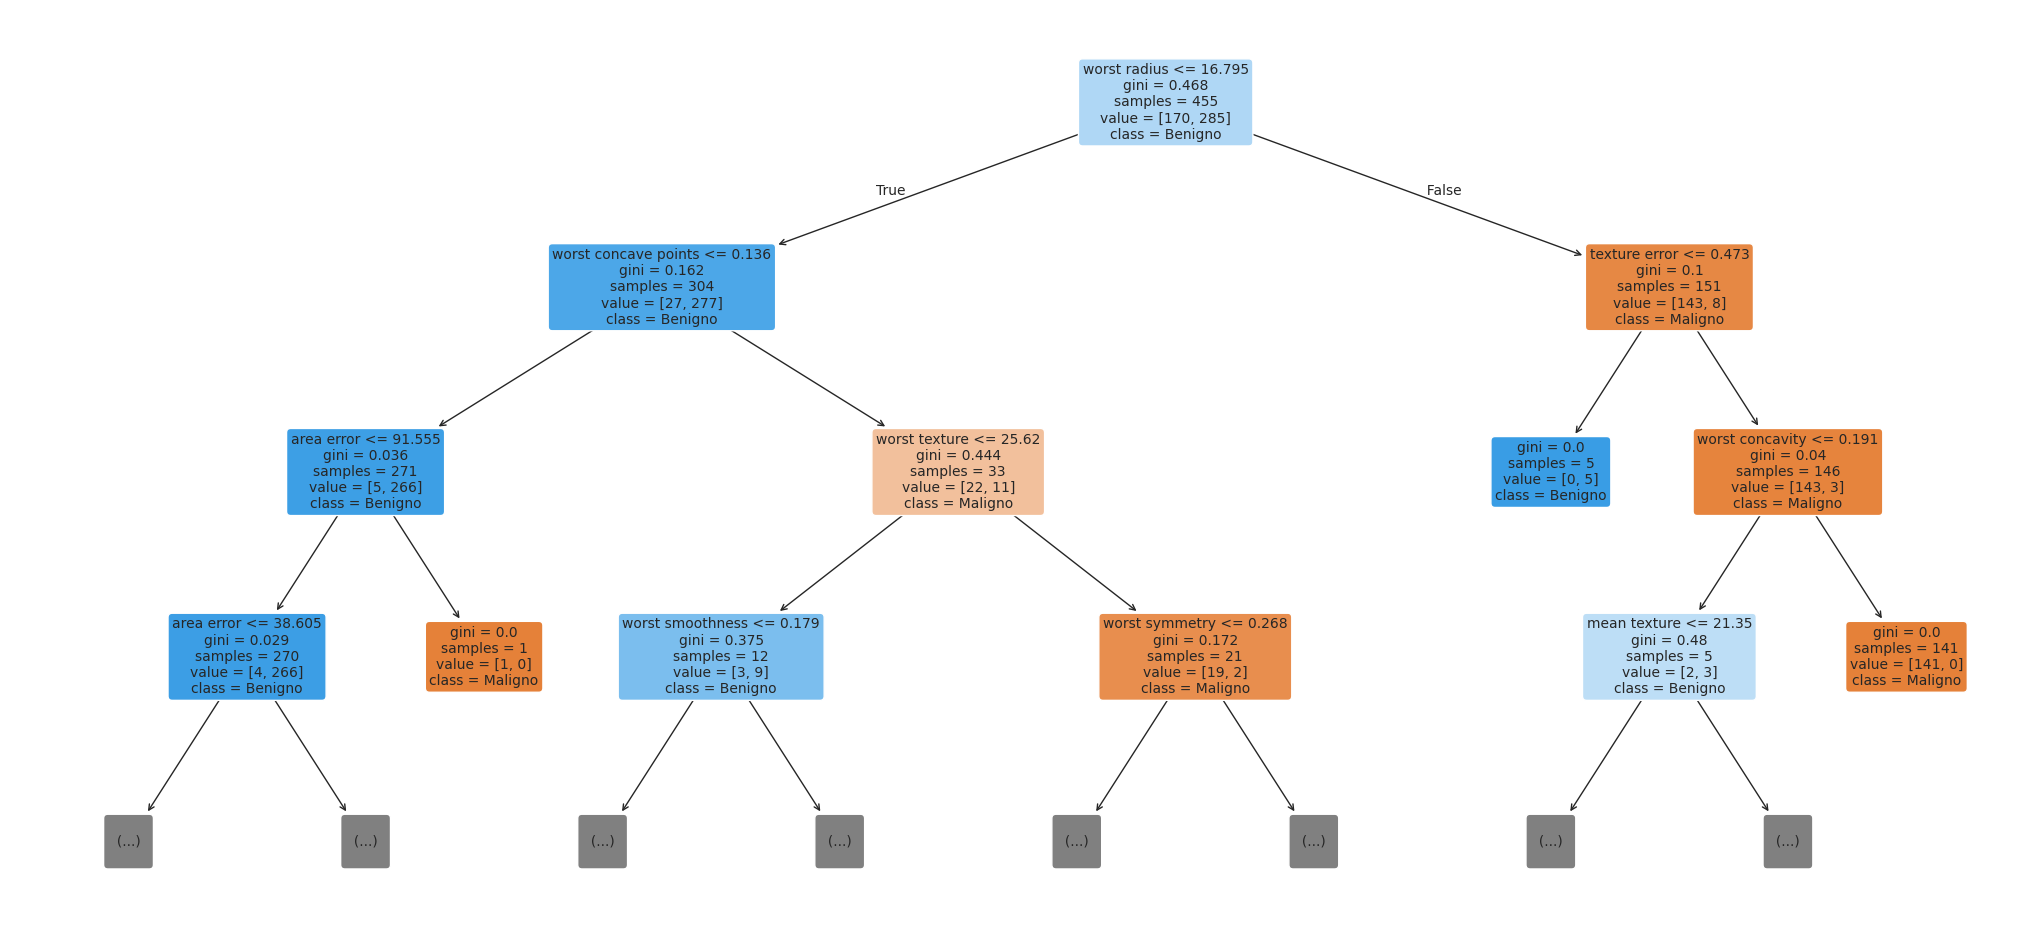

In [29]:
from sklearn.tree import plot_tree

plt.figure(figsize=(26,12))
plot_tree(clf, feature_names=X.columns, class_names=["Maligno", "Benigno"], filled=True, rounded=True, fontsize=10, max_depth=3)
plt.show()



**Cómo leer un nodo**:
- Regla (p. ej. `worst concave points ≤ 0.16`).
- `samples`: cuántas muestras pasan por ese nodo.
- `value=[m,b]`: conteos de **maligno** y **benigno**.
- `class`: clase mayoritaria asignada.
- `color`: intensidad de pureza (cuanto más uniforme, más intenso hacia la clase).

**Interpretación típica**:
- Si `worst concave points` es bajo → gran parte de los casos es **benigna**.
- Si es alto y además `worst radius` es alto → mayor probabilidad de **maligno**.
- Cada rama encadena criterios morfológicos hasta llegar a hojas muy puras.



## ¿Qué aprendimos y qué sigue?

Un **árbol de clasificación**:
- Divide el espacio de variables en **regiones** maximizando la **pureza** de clase.
- Entrega **reglas legibles** y auditables.
- Funciona **sin escalado ni encoding** si las *features* son numéricas.
- Logra **alta exactitud** en este dataset con poco ajuste.

**Siguientes pasos sugeridos**:
- Ajustar `min_samples_leaf` y `max_depth` para **mejorar `recall` de “Maligno”**.
- Comparar con **RandomForest** o **Gradient Boosting** (mejor generalización).
- Trabajar con **umbral de decisión** usando `predict_proba` si priorizas seguridad clínica (más *recall*).
